# Replication of Darcy Flow Continuous

Current Directory /home/henry/school/v-igno/src/notebooks
The shape of x_train: torch.Size([1000, 841, 2])
The shape of a_train: torch.Size([1000, 841, 1])
The shape of gridx_train: torch.Size([841, 2])
**********************************
The shape of x_test: torch.Size([200, 841, 2])
The shape of a_test: torch.Size([200, 841, 1])
The shape of u_test: torch.Size([200, 841, 1])
The shape of gridx_test: torch.Size([841, 2])


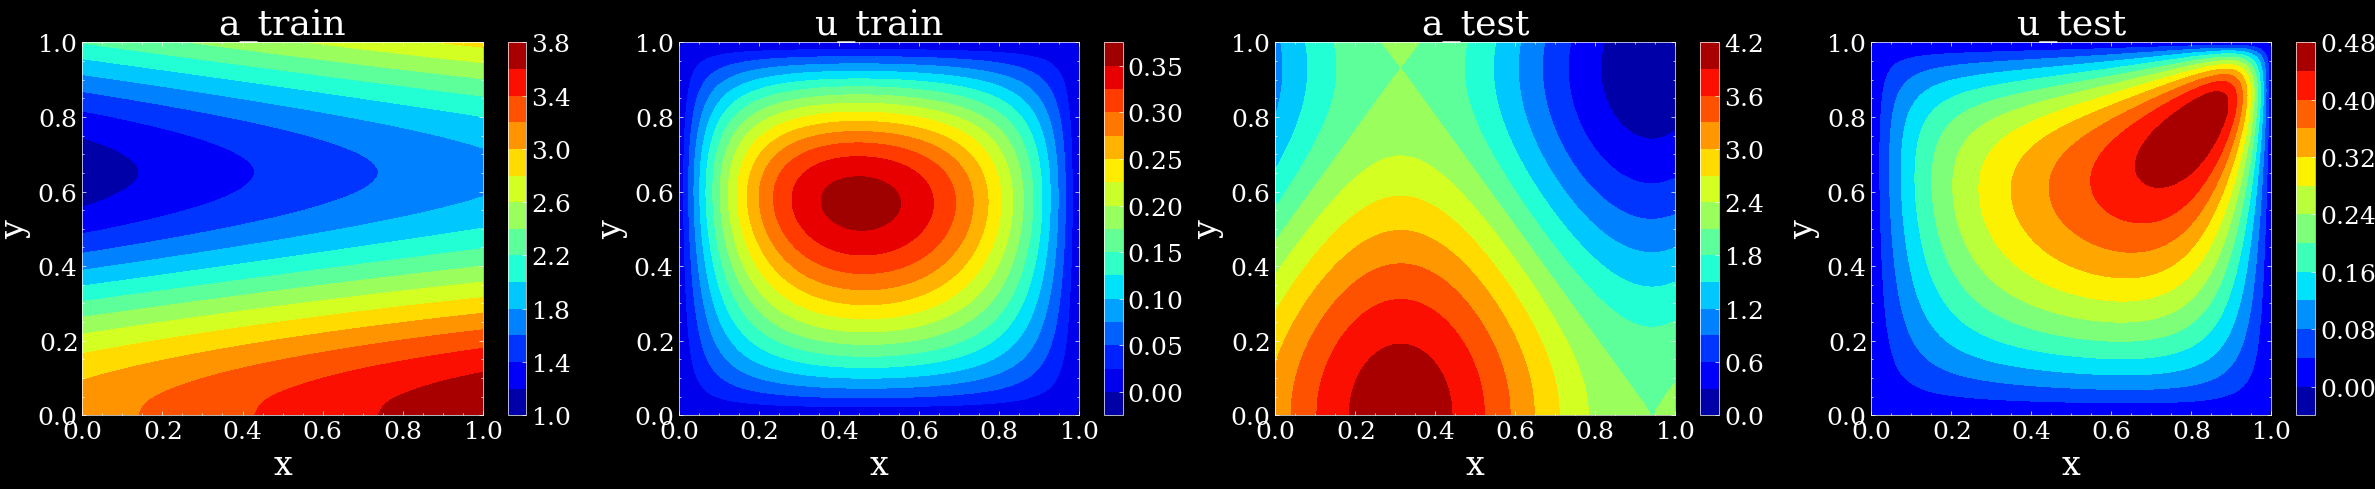

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("../..")))

from src.solver.config import OptimizerConfig, SchedulerConfig, LossWeights

from typing import Dict, Optional

import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt

from src.utils.solver_utils import get_model



from src.solver.base import ProblemInstance, Solver
from src.utils.misc_utils import np2tensor, setup_seed, get_default_device
from src.utils.RBFInterpolatorMesh import RBFInterpolator
from src.utils.PlotFigure import Plot
from src.components.encoder import EncoderCNNet2dTanh

print(f'Current Directory {os.getcwd()}')

setup_seed(seed=10086)
device = get_default_device()
dtype = torch.float32

######################################
# Load training data
######################################


def get_data(data, dtype):
    a = np2tensor(np.array(data["coeff"]).T, dtype)
    u = np2tensor(np.array(data["sol"]).T, dtype)
    #
    X, Y = np.array(data['X']).T, np.array(data['Y']).T
    mesh = np2tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype)
    gridx = mesh.reshape(-1, 2)
    #
    ndata = a.shape[0]
    a = a.reshape(ndata, -1, 1)
    x = gridx.repeat((ndata, 1, 1))
    u = u.reshape(ndata, -1, 1)

    return a, u, x, gridx
#
data_train = h5py.File('../../data/darcy_continuous/smh_train.mat', 'r')
data_test = h5py.File('../../data/darcy_continuous/smh_test_in.mat', 'r')
a_train, u_train, x_train, gridx_train = get_data(data_train, dtype)
a_test, u_test, x_test, gridx_test = get_data(data_test, dtype)
#
print('The shape of x_train:', x_train.shape)
print('The shape of a_train:', a_train.shape)
print('The shape of gridx_train:', gridx_train.shape)
print('**********************************')
print('The shape of x_test:', x_test.shape)
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of gridx_test:', gridx_test.shape)
########################################
Plot.show_2d_list(
    [gridx_train.cpu().numpy()]*3 + [gridx_test.cpu().numpy()],
    [a_train[0].cpu().numpy(), u_train[0].cpu().numpy(),
     a_test[0].cpu().numpy(), u_test[0].cpu().numpy()],
    ['a_train', 'u_train', 'a_test', 'u_test'],
    lb=0.
)


## Generate points and integral grid

In [2]:
import torch.nn as nn
from torch.autograd import grad, Variable
from src.utils.TestFun_ParticleWNN import TestFun_ParticleWNN
from src.utils.GenPoints import Point2D

genPoint = Point2D(x_lb=[0., 0.], x_ub=[1., 1.], dataType=dtype)

###############################
# The test function
###############################
int_grid, v, dv_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=9, dataType=dtype).get_testFun()
print('int_grid shape:', int_grid.shape, 'v shape:', v.shape)



int_grid shape: torch.Size([45, 2]) v shape: torch.Size([45, 1])


## Mollifier

In [3]:
class Mollifier:

    def __call__(self, u, x):
        u = u * torch.sin(np.pi * x[...,0])*torch.sin(np.pi * x[...,1])
        return u.unsqueeze(-1)


## Models

In [4]:
net_type = 'MultiONetBatch'
beta_size = 128
hidden_size = 100
# Copied from DGNO
fun_a = RBFInterpolator(
    x_mesh=gridx_train,
    kernel='gaussian',
    eps=25.,
    smoothing=0.,
    degree=6,
    dtype=dtype
)

############ Encoder Architecture ########
conv_arch = [1,64,64,64]
fc_arch = [64*2*2, 128, 128, beta_size]
model_enc = EncoderCNNet2dTanh(
    conv_arch=conv_arch,
    fc_arch=fc_arch,
    activation_conv='SiLU',
    activation_fc='SiLU',
    nx_size=29,
    ny_size=29,
    kernel_size=(3,3),
    stride=2,
    dtype=dtype
)

############ Decoder Architecture
trunk_layers, branch_layers = [hidden_size] * 6, [hidden_size] * 6
#
model_a = get_model(
    x_in_size=2,
    beta_in_size=beta_size,
    trunk_layers=trunk_layers,
    branch_layers=branch_layers,
    activation_trunk='Tanh_Sin',
    activation_branch='Tanh_Sin',
    net_type=net_type,
    sum_layers=5
)


model_u = get_model(
    x_in_size=2,
    beta_in_size=beta_size,
    trunk_layers=trunk_layers,
    branch_layers=branch_layers,
    activation_trunk='Tanh_Sin',
    activation_branch='Tanh_Sin',
    net_type=net_type,
    sum_layers=5
)
####################
total_trainable_params_enc = sum(p.numel() for p in model_enc.parameters() if p.requires_grad)
print(f'{total_trainable_params_enc:,} training parameters.')
total_trainable_params_u = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params_u:,} training parameters.')
#
print(f'{total_trainable_params_enc + total_trainable_params_u*2:,} total parameters')


140,416 training parameters.
114,206 training parameters.
368,828 total parameters


## Problem Instance

In [5]:



class DarcyFlowContinuous(ProblemInstance):

    def __init__(self):
        super().__init__(
            device=device,
            dtype=dtype
        )

        self.mollifier = Mollifier()
        self.n_grid = int_grid.shape[0]
        self.int_grid = int_grid.to(self.device)
        self.v = v.to(self.device)
        self.dv_dr = dv_dr.to(self.device)
        self.model_dict = {
            'u': model_u,
            'a': model_a,
            'enc': model_enc
        }

    def loss_pde(self, a: torch.Tensor, nc=100) -> torch.Tensor:
        n_batch = a.shape[0]
        beta = self.model_dict['enc'](a)

        ##### Data points
        # cx:size(nc,1,2) R:Size(nc,1,1)
        xc, R = genPoint.weight_centers(n_center=nc, R_max=1e-4, R_min=1e-4)
        xc, R = xc.to(self.device), R.to(self.device)

        # size(nc,n_grid,2)
        x = self.int_grid * R + xc
        #size(nc*n_grid, 2) -> (n_batch, nc*n_grid, 2)
        x = x.reshape(-1,2).repeat((n_batch,1,1))
        x = Variable(x, requires_grad=True)

        ############ Test functions ############
        v = self.v.repeat((nc,1,1)).reshape(-1,1)
        dv = (self.dv_dr / R).reshape(-1,2)
        ############ Model prediction #########
        a_detach = fun_a(x.detach(), a)
        u = self.model_dict['u'](x, beta)
        u = self.mollifier(u, x)

        du = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        f = 10. * torch.ones_like(u)
        ################ PDE loss ####################
        # size(n_batch, nc*n_grid, 2) -> (n_batch, nc, n_grid) -> (n_batch, nc)
        left = torch.sum( a_detach*du*dv, dim=-1).reshape(n_batch, nc, self.n_grid)
        left = torch.mean(left, dim=-1)
        # size(n_batch, nc*n_grid, 1) -> (n_batch, nc, n_grid) -> (n_batch, nc)
        right = (f * v).reshape(n_batch, nc, self.n_grid)
        right = torch.mean(right, dim=-1)
        ################################################
        res = (left-right)**2
        res, indices = torch.sort(res.flatten(), descending=True, dim=0)
        loss_res = torch.sum( res[0:100*10] )

        return self.get_loss(left, right) + loss_res


    def loss_data(self, x: torch.Tensor, a: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
        beta = self.model_dict['enc'](a)
        a_pred = self.model_dict['a'](x, beta)
        return self.get_loss(a_pred, a.squeeze(-1))

    def get_model_dict(self) -> Dict[str, nn.Module]:
        return self.model_dict

    def error(self, x: torch.Tensor, a: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
        beta = self.model_dict['enc'](a)
        u_pred = self.model_dict['u'](x, beta)
        u_pred = self.mollifier(u_pred, x)

        return self.get_loss(u_pred, u)


# Train

In [7]:
solver = Solver(
    problem_instance=DarcyFlowContinuous(),
)

solver.train_mbgd(
    a_train=a_train,
    u_train=u_train,
    x_train=x_train,
    a_test=a_test,
    u_test=u_test,
    x_test=x_test,
    optimizer_config=OptimizerConfig(
        'AdamW',
        lr=5e-4
    ),
    scheduler_config=SchedulerConfig(
        type='StepLR',
        step_size=np.int32(2000/5),
        gamma=0.5,
    ),
    loss_weights=LossWeights(
        pde=1.0,
        data=0.25,
        beta=0.0
    ),
    batch_size=50,
    epochs=2000,
    epoch_show=50,
    custom_run_tag='first_trial_run'
)


  0%|          | 0/2000 [00:08<?, ?it/s]


KeyboardInterrupt: 